# Assignment 2

In this assignment, we are working with a small image dataset, known as the `FashionMNIST`.

We will be building different neural networks to perform classification of the images.

Let's first load the dataset using the torch vision API.

In [53]:
# [THIS IS READ-ONLY]
from importlib import reload
import warnings
warnings.filterwarnings('ignore')

import torchvision

dataset = torchvision.datasets.FashionMNIST(
    '../data/',
    train=True,
    transform=torchvision.transforms.ToTensor(),
)
dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../data/
    Split: Train
    StandardTransform
Transform: ToTensor()

# Understanding the dataset

The dataset contains grayscale images of various fashion articles from 10 different categories.

In [54]:
# [THIS IS READ-ONLY]
num_classes = len(dataset.classes)
list(enumerate(dataset.classes))

[(0, 'T-shirt/top'),
 (1, 'Trouser'),
 (2, 'Pullover'),
 (3, 'Dress'),
 (4, 'Coat'),
 (5, 'Sandal'),
 (6, 'Shirt'),
 (7, 'Sneaker'),
 (8, 'Bag'),
 (9, 'Ankle boot')]

You can see that the categories are shown above, with the target label as an integer from 0 to 9.

Let's sample some `Dress` which uses the integer value 3.

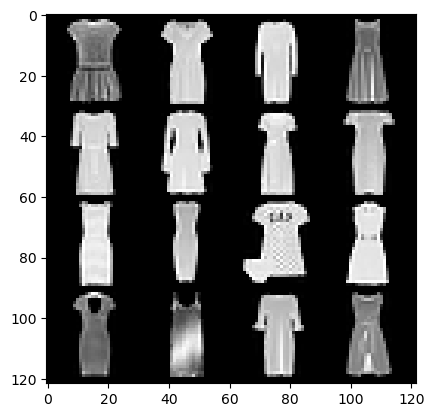

In [55]:
# [THIS IS READ-ONLY]
import torchvision
import matplotlib.pyplot as pl

I_dress = dataset.targets == 3
x_dress = dataset.data[I_dress, :, :]
x_dress = x_dress[:16, None, :, :]

grid = torchvision.utils.make_grid(x_dress, nrow=4)
pl.imshow(grid.permute(1, 2, 0));

Let's understand the dataset a bit better by examining the samples.

We will get the first sample as a tuple of `(input, target)`.

- The input is a tensor of shape `(1, 28, 28)`.  It is an image with 1 channel and dimension 28x28.

- The target is an integer label.

In [56]:
# [THIS IS READ-ONLY]
(x, y) = dataset[0]
print("First sample: (x, target)")
print(f"- type of x: {type(x)} with shape {x.shape}")
print(f"- type of target: {type(y)} with value {y}")

First sample: (x, target)
- type of x: <class 'torch.Tensor'> with shape torch.Size([1, 28, 28])
- type of target: <class 'int'> with value 9


## Preparing training and validation data

In [57]:
# [THIS IS READ-ONLY]
#
# Prepare training and validation
#
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader

# Move tensors to GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# dataset.data = dataset.data.to(device)
# dataset.targets = dataset.targets.to(device)

batch_size = 128
training_dataset, val_dataset = random_split(
    dataset,
    (0.7, 0.3),
    generator=torch.Generator().manual_seed(0))
training_dataloader = DataLoader(training_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Helper functions

In [58]:
# [THIS IS READ-ONLY]
#
# This function describes the architecture of the model
# in terms of its layers, as well as computing
# the total number of parameters the model uses.
#
import torchinfo
def describe(model, **kwargs):
    return torchinfo.summary(model,
                             input_size=(batch_size, 1, 28, 28),
                             col_names=['input_size', 'output_size', 'kernel_size', 'num_params'],
                             row_settings=['ascii_only'])

In [59]:
# [THIS IS READ-ONLY]
#
# This function performs training using Lightning trainer.
# It saves the model checkpoint under ./lightning_logs/.../version_0
# The logged metrics will also be saved here.
#

import shutil
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch import Trainer, seed_everything

def train(model):
    name = model.__class__.__name__
    shutil.rmtree(f'./lightning_logs/{name}', ignore_errors=True)
    seed_everything(0, workers=True)
    logger = CSVLogger('./lightning_logs', name=name)
    trainer = Trainer(max_epochs=3, logger=logger, deterministic=True, accelerator='gpu', devices=1)
    trainer.fit(model,
                train_dataloaders=training_dataloader,
                val_dataloaders=val_dataloader)

In [60]:
# [THIS IS READ-ONLY]
#
# This function loads the training metrics from the
# log file, and plots the training and validation accuracies.
#

import pandas as pd

def show_metrics(name):
    df = pd.read_csv(f'./lightning_logs/{name}/version_0/metrics.csv')
    df.set_index('step', inplace=True)
    ax = df[['train_step_acc']].dropna().plot()
    df[['val_step_acc']].dropna().plot(ax=ax);
    return df[['val_step_acc']].dropna().round(2)

# Linear Model

In [61]:
# [THIS IS READ-ONLY]
# @check
# @title: linear model description

import models
reload(models)
model = models.LinearModel(num_classes)
describe(model)

Layer (type)                             Input Shape               Output Shape              Kernel Shape              Param #
LinearModel                              [128, 1, 28, 28]          [128, 10]                 --                        --
+ Linear                                 [128, 784]                [128, 10]                 --                        7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.00
Input size (MB): 0.40
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.44

In [62]:
# [THIS IS READ-ONLY]
reload(models)
model = models.LinearModel(num_classes)
train(model)

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0      | train
1 | model    | Linear             | 7.9 K  | train
--------------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [63]:
# [THIS IS READ-ONLY]
! tree -n ./lightning_logs/LinearModel

./lightning_logs/LinearModel
└── version_0
    ├── checkpoints
    │   └── epoch=2-step=987.ckpt
    ├── hparams.yaml
    └── metrics.csv

2 directories, 3 files


,val_step_acc
step,
328,0.76
657,0.82
986,0.83


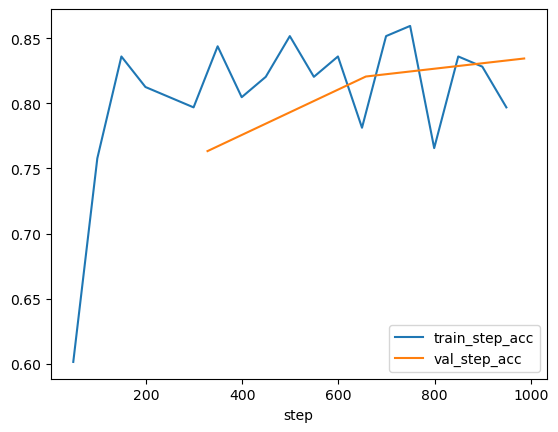

In [64]:
# [THIS IS READ-ONLY]
show_metrics('LinearModel')

# MLP

In [65]:
# [THIS IS READ-ONLY]
# @check
# @title: MLP description

reload(models)
model = models.MLP(num_classes, 100)
describe(model)

Layer (type)                             Input Shape               Output Shape              Kernel Shape              Param #
MLP                                      [128, 1, 28, 28]          [128, 10]                 --                        --
+ Sequential                             [128, 784]                [128, 10]                 --                        --
|    + Linear                            [128, 784]                [128, 100]                --                        78,500
|    + ReLU                              [128, 100]                [128, 100]                --                        --
|    + Linear                            [128, 100]                [128, 10]                 --                        1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 10.18
Input size (MB): 0.40
Forward/backward pass size (MB): 0.11
Params size (MB): 0.32
Estimated Total Size (MB): 0.83

In [66]:
# [THIS IS READ-ONLY]
reload(models)
model = models.MLP(num_classes, 100)
train(model)

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0      | train
1 | model    | Sequential         | 79.5 K | train
--------------------------------------------------------
79.5 K    Trainable params
0         Non-trainable params
79.5 K    Total params
0.318     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [67]:
# [THIS IS READ-ONLY]
! tree -n ./lightning_logs/MLP

./lightning_logs/MLP
└── version_0
    ├── checkpoints
    │   └── epoch=2-step=987.ckpt
    ├── hparams.yaml
    └── metrics.csv

2 directories, 3 files


,val_step_acc
step,
328,0.79
657,0.84
986,0.85


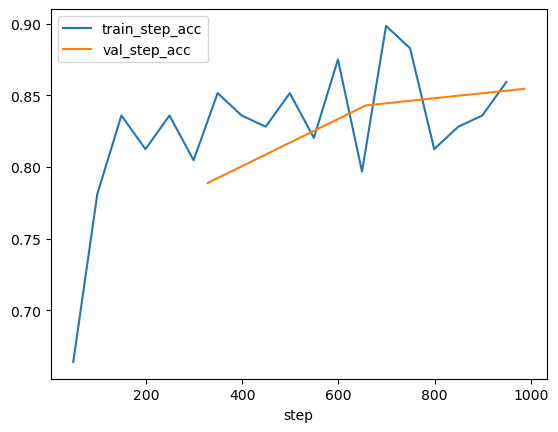

In [68]:
# [THIS IS READ-ONLY]
show_metrics('MLP')

# ConvNet

In [69]:
# [THIS IS READ-ONLY]
# @check
# @title: ConvNet description

reload(models)
model = models.ConvNet(num_classes, 5, 3, 2)
describe(model)

Layer (type)                             Input Shape               Output Shape              Kernel Shape              Param #
ConvNet                                  [128, 1, 28, 28]          [128, 10]                 --                        --
+ Sequential                             [128, 1, 28, 28]          [128, 10]                 --                        --
|    + Conv2d                            [128, 1, 28, 28]          [128, 5, 26, 26]          [3, 3]                    50
|    + ReLU                              [128, 5, 26, 26]          [128, 5, 26, 26]          --                        --
|    + MaxPool2d                         [128, 5, 26, 26]          [128, 5, 13, 13]          2                         --
|    + Flatten                           [128, 5, 13, 13]          [128, 845]                --                        --
|    + Linear                            [128, 845]                [128, 10]                 --                        8,460
Total params: 8,

In [70]:
# [THIS IS READ-ONLY]
reload(models)
model = models.ConvNet(num_classes, 5, 3, 2)
train(model)

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0      | train
1 | model    | Sequential         | 8.5 K  | train
--------------------------------------------------------
8.5 K     Trainable params
0         Non-trainable params
8.5 K     Total params
0.034     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


,val_step_acc
step,
328,0.78
657,0.84
986,0.85


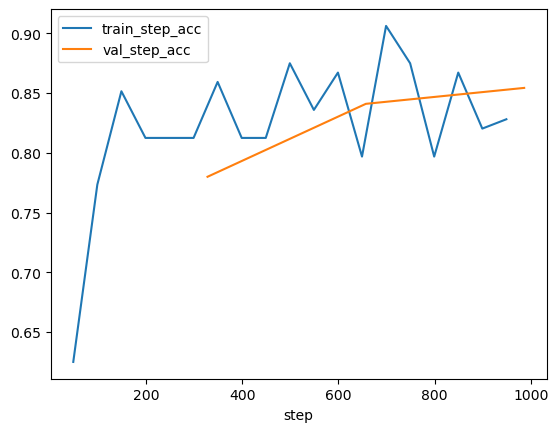

In [71]:
# [THIS IS READ-ONLY]
show_metrics('ConvNet')

# Two layer ConvNet

In [72]:
# [THIS IS READ-ONLY]
# @check
# @title: two layer convnet description

reload(models)
model = models.DeepConvNet(num_classes)
describe(model)

Layer (type)                             Input Shape               Output Shape              Kernel Shape              Param #
DeepConvNet                              [128, 1, 28, 28]          [128, 10]                 --                        --
+ Sequential                             [128, 1, 28, 28]          [128, 10]                 --                        --
|    + Conv2d                            [128, 1, 28, 28]          [128, 32, 26, 26]         [3, 3]                    320
|    + ReLU                              [128, 32, 26, 26]         [128, 32, 26, 26]         --                        --
|    + MaxPool2d                         [128, 32, 26, 26]         [128, 32, 13, 13]         2                         --
|    + Conv2d                            [128, 32, 13, 13]         [128, 64, 11, 11]         [3, 3]                    18,496
|    + ReLU                              [128, 64, 11, 11]         [128, 64, 11, 11]         --                        --
|    + MaxPool

In [73]:
# [THIS IS READ-ONLY]
reload(models)
model = models.DeepConvNet(num_classes)
train(model)

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0      | train
1 | model    | Sequential         | 225 K  | train
--------------------------------------------------------
225 K     Trainable params
0         Non-trainable params
225 K     Total params
0.900     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


,val_step_acc
step,
328,0.78
657,0.85
986,0.87


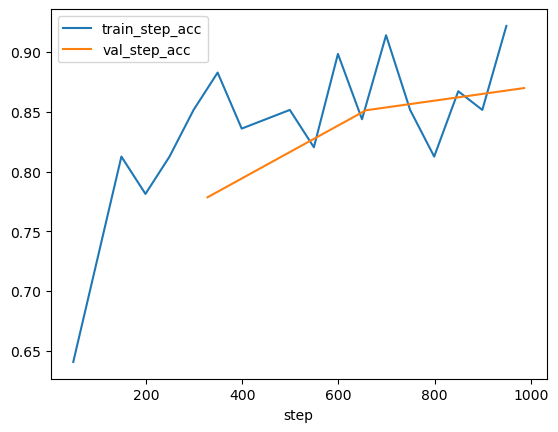

In [74]:
# [THIS IS READ-ONLY]
show_metrics('DeepConvNet')